In [ ]:
import torch

In [24]:

from diffusers.pipelines.flux.pipeline_flux import FluxPipeline, calculate_shift, retrieve_timesteps
from diffusers.pipelines.flux.pipeline_output import FluxPipelineOutput
from diffusers.image_processor import PipelineImageInput
from diffusers.loaders import FluxLoraLoaderMixin, TextualInversionLoaderMixin
import torch
from typing import Union, List, Optional, Dict, Any, Callable
import numpy as np
from diffusers.utils import (
    USE_PEFT_BACKEND,
    scale_lora_layers,
    unscale_lora_layers
)

class DiffusionLensFluxPipeline(FluxPipeline):
  def _get_t5_prompt_embeds(
    self,
    prompt: Union[str, List[str]] = None,
    num_images_per_prompt: int = 1,
    max_sequence_length: int = 512,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    skip_layers: Optional[int] = 0,
  ):
    device = device or self._execution_device
    dtype = dtype or self.text_encoder.dtype
    prompt = [prompt] if isinstance(prompt, str) else prompt
    batch_size = len(prompt)
    if isinstance(self, TextualInversionLoaderMixin):
        prompt = self.maybe_convert_prompt(prompt, self.tokenizer_2)
    text_inputs = self.tokenizer_2(
        prompt,
        padding="max_length",
        max_length=max_sequence_length,
        truncation=True,
        return_length=False,
        return_overflowing_tokens=False,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    untruncated_ids = self.tokenizer_2(prompt, padding="longest", return_tensors="pt").input_ids
    if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
        removed_text = self.tokenizer_2.batch_decode(untruncated_ids[:, self.tokenizer_max_length - 1 : -1])
        # logger.warning(
        #     "The following part of your input was truncated because `max_sequence_length` is set to "
        #     f" {max_sequence_length} tokens: {removed_text}"
        # )

    prompt_embeds = self.text_encoder_2(text_input_ids.to(device), output_hidden_states=True)

    if skip_layers is None or skip_layers == 0:
        print("skip_layers is None or 0: ", skip_layers)
        print("Not skiping layers")
        prompt_embeds = prompt_embeds.hidden_states[-1]
    else:
        print("Skiping num layers: ", skip_layers)
        if skip_layers > len(prompt_embeds.hidden_states):
            print(f"skip_layers is greater than the number of layers in the model - setting to max value: {len(prompt_embeds.hidden_states)}")
            skip_layers = len(prompt_embeds.hidden_states) - 1
        prompt_embeds = prompt_embeds.hidden_states[-(skip_layers + 1)]
        # TODO check if needed
        prompt_embeds = self.text_encoder_2.encoder.final_layer_norm(prompt_embeds)


    # prompt_embeds = self.text_encoder_2(text_input_ids.to(device), output_hidden_states=True)[0]
    dtype = self.text_encoder_2.dtype
    prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)
    _, seq_len, _ = prompt_embeds.shape
    # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)
    return prompt_embeds

  def _get_clip_prompt_embeds(
    self,
    prompt: Union[str, List[str]],
    num_images_per_prompt: int = 1,
    device: Optional[torch.device] = None,
    skip_layers: Optional[int] = 0,
  ):
    device = device or self._execution_device
    prompt = [prompt] if isinstance(prompt, str) else prompt
    batch_size = len(prompt)
    if isinstance(self, TextualInversionLoaderMixin):
        prompt = self.maybe_convert_prompt(prompt, self.tokenizer)
    text_inputs = self.tokenizer(
        prompt,
        padding="max_length",
        max_length=self.tokenizer_max_length,
        truncation=True,
        return_overflowing_tokens=False,
        return_length=False,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids
    if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
        removed_text = self.tokenizer.batch_decode(untruncated_ids[:, self.tokenizer_max_length - 1 : -1])
        # logger.warning(
        #     "The following part of your input was truncated because CLIP can only handle sequences up to"
        #     f" {self.tokenizer_max_length} tokens: {removed_text}"
        # )
    if skip_layers is not None and skip_layers > 0:
      text_inputs_empty = self.tokenizer(
        '',
        padding="max_length",
        max_length=self.tokenizer_max_length,
        truncation=True,
        return_overflowing_tokens=False,
        return_length=False,
        return_tensors="pt",
      )
      text_input_ids_empty = text_inputs_empty.input_ids
      prompt_embeds = self.text_encoder(text_input_ids_empty.to(device), output_hidden_states=False)
      print("Clip is masked")
    else:
      prompt_embeds = self.text_encoder(text_input_ids.to(device), output_hidden_states=False)



    # Use pooled output of CLIPTextModel
    prompt_embeds = prompt_embeds.pooler_output
    prompt_embeds = prompt_embeds.to(dtype=self.text_encoder.dtype, device=device)
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, -1)
    return prompt_embeds

  def encode_prompt(
      self,
      prompt: Union[str, List[str]],
      prompt_2: Union[str, List[str]],
      device: Optional[torch.device] = None,
      num_images_per_prompt: int = 1,
      prompt_embeds: Optional[torch.FloatTensor] = None,
      pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
      max_sequence_length: int = 512,
      lora_scale: Optional[float] = None,
      skip_layers: Optional[int] = None
  ):
    r"""
    Args:
        prompt (`str` or `List[str]`, *optional*):
            prompt to be encoded
        prompt_2 (`str` or `List[str]`, *optional*):
            The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
            used in all text-encoders
        device: (`torch.device`):
            torch device
        num_images_per_prompt (`int`):
            number of images that should be generated per prompt
        prompt_embeds (`torch.FloatTensor`, *optional*):
            Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
            provided, text embeddings will be generated from `prompt` input argument.
        pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
            Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
            If not provided, pooled text embeddings will be generated from `prompt` input argument.
        lora_scale (`float`, *optional*):
            A lora scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
    """
    device = device or self._execution_device
    # set lora scale so that monkey patched LoRA
    # function of text encoder can correctly access it
    if lora_scale is not None and isinstance(self, FluxLoraLoaderMixin):
        self._lora_scale = lora_scale
        # dynamically adjust the LoRA scale
        if self.text_encoder is not None and USE_PEFT_BACKEND:
            scale_lora_layers(self.text_encoder, lora_scale)
        if self.text_encoder_2 is not None and USE_PEFT_BACKEND:
            scale_lora_layers(self.text_encoder_2, lora_scale)
    prompt = [prompt] if isinstance(prompt, str) else prompt
    if prompt_embeds is None:
        prompt_2 = prompt_2 or prompt
        prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2
        # We only use the pooled prompt output from the CLIPTextModel
        pooled_prompt_embeds = self._get_clip_prompt_embeds(
            prompt=prompt,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            skip_layers=skip_layers
        )
        prompt_embeds = self._get_t5_prompt_embeds(
            prompt=prompt_2,
            num_images_per_prompt=num_images_per_prompt,
            max_sequence_length=max_sequence_length,
            device=device,
            skip_layers=skip_layers
        )
    if self.text_encoder is not None:
        if isinstance(self, FluxLoraLoaderMixin) and USE_PEFT_BACKEND:
            # Retrieve the original scale by scaling back the LoRA layers
            unscale_lora_layers(self.text_encoder, lora_scale)
    if self.text_encoder_2 is not None:
        if isinstance(self, FluxLoraLoaderMixin) and USE_PEFT_BACKEND:
            # Retrieve the original scale by scaling back the LoRA layers
            unscale_lora_layers(self.text_encoder_2, lora_scale)
    dtype = self.text_encoder.dtype if self.text_encoder is not None else self.transformer.dtype
    text_ids = torch.zeros(prompt_embeds.shape[1], 3).to(device=device, dtype=dtype)
    return prompt_embeds, pooled_prompt_embeds, text_ids


  @torch.no_grad()
  def __call__(
      self,
      prompt: Union[str, List[str]] = None,
      prompt_2: Optional[Union[str, List[str]]] = None,
      negative_prompt: Union[str, List[str]] = None,
      negative_prompt_2: Optional[Union[str, List[str]]] = None,
      true_cfg_scale: float = 1.0,
      height: Optional[int] = None,
      width: Optional[int] = None,
      num_inference_steps: int = 28,
      sigmas: Optional[List[float]] = None,
      guidance_scale: float = 3.5,
      num_images_per_prompt: Optional[int] = 1,
      generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
      latents: Optional[torch.FloatTensor] = None,
      prompt_embeds: Optional[torch.FloatTensor] = None,
      pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
      ip_adapter_image: Optional[PipelineImageInput] = None,
      ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
      negative_ip_adapter_image: Optional[PipelineImageInput] = None,
      negative_ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
      negative_prompt_embeds: Optional[torch.FloatTensor] = None,
      negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
      output_type: Optional[str] = "pil",
      return_dict: bool = True,
      joint_attention_kwargs: Optional[Dict[str, Any]] = None,
      callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
      callback_on_step_end_tensor_inputs: List[str] = ["latents"],
      max_sequence_length: int = 512,
      skip_layers: int = 0,
  ):
      r"""
      Function invoked when calling the pipeline for generation.
      Args:
          prompt (`str` or `List[str]`, *optional*):
              The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
              instead.
          prompt_2 (`str` or `List[str]`, *optional*):
              The prompt or prompts to be sent to `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
              will be used instead.
          negative_prompt (`str` or `List[str]`, *optional*):
              The prompt or prompts not to guide the image generation. If not defined, one has to pass
              `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `true_cfg_scale` is
              not greater than `1`).
          negative_prompt_2 (`str` or `List[str]`, *optional*):
              The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
              `text_encoder_2`. If not defined, `negative_prompt` is used in all the text-encoders.
          true_cfg_scale (`float`, *optional*, defaults to 1.0):
              When > 1.0 and a provided `negative_prompt`, enables true classifier-free guidance.
          height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
              The height in pixels of the generated image. This is set to 1024 by default for the best results.
          width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
              The width in pixels of the generated image. This is set to 1024 by default for the best results.
          num_inference_steps (`int`, *optional*, defaults to 50):
              The number of denoising steps. More denoising steps usually lead to a higher quality image at the
              expense of slower inference.
          sigmas (`List[float]`, *optional*):
              Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
              their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
              will be used.
          guidance_scale (`float`, *optional*, defaults to 7.0):
              Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
              `guidance_scale` is defined as `w` of equation 2. of [Imagen
              Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
              1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
              usually at the expense of lower image quality.
          num_images_per_prompt (`int`, *optional*, defaults to 1):
              The number of images to generate per prompt.
          generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
              One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
              to make generation deterministic.
          latents (`torch.FloatTensor`, *optional*):
              Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
              generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
              tensor will ge generated by sampling using the supplied random `generator`.
          prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
              provided, text embeddings will be generated from `prompt` input argument.
          pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
              If not provided, pooled text embeddings will be generated from `prompt` input argument.
          ip_adapter_image: (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
          ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
              Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
              IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. If not
              provided, embeddings are computed from the `ip_adapter_image` input argument.
          negative_ip_adapter_image:
              (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
          negative_ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
              Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
              IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. If not
              provided, embeddings are computed from the `ip_adapter_image` input argument.
          negative_prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
              weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
              argument.
          negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
              Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
              weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
              input argument.
          output_type (`str`, *optional*, defaults to `"pil"`):
              The output format of the generate image. Choose between
              [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
          return_dict (`bool`, *optional*, defaults to `True`):
              Whether or not to return a [`~pipelines.flux.FluxPipelineOutput`] instead of a plain tuple.
          joint_attention_kwargs (`dict`, *optional*):
              A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
              `self.processor` in
              [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
          callback_on_step_end (`Callable`, *optional*):
              A function that calls at the end of each denoising steps during the inference. The function is called
              with the following arguments: `callback_on_step_end(self: DiffusionPipeline, step: int, timestep: int,
              callback_kwargs: Dict)`. `callback_kwargs` will include a list of all tensors as specified by
              `callback_on_step_end_tensor_inputs`.
          callback_on_step_end_tensor_inputs (`List`, *optional*):
              The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
              will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
              `._callback_tensor_inputs` attribute of your pipeline class.
          max_sequence_length (`int` defaults to 512): Maximum sequence length to use with the `prompt`.
      Examples:
      Returns:
          [`~pipelines.flux.FluxPipelineOutput`] or `tuple`: [`~pipelines.flux.FluxPipelineOutput`] if `return_dict`
          is True, otherwise a `tuple`. When returning a tuple, the first element is a list with the generated
          images.
      """
      height = height or self.default_sample_size * self.vae_scale_factor
      width = width or self.default_sample_size * self.vae_scale_factor
      # 1. Check inputs. Raise error if not correct
      self.check_inputs(
          prompt,
          prompt_2,
          height,
          width,
          negative_prompt=negative_prompt,
          negative_prompt_2=negative_prompt_2,
          prompt_embeds=prompt_embeds,
          negative_prompt_embeds=negative_prompt_embeds,
          pooled_prompt_embeds=pooled_prompt_embeds,
          negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
          callback_on_step_end_tensor_inputs=callback_on_step_end_tensor_inputs,
          max_sequence_length=max_sequence_length,
      )
      self._guidance_scale = guidance_scale
      self._joint_attention_kwargs = joint_attention_kwargs
      self._interrupt = False
      # 2. Define call parameters
      if prompt is not None and isinstance(prompt, str):
          batch_size = 1
      elif prompt is not None and isinstance(prompt, list):
          batch_size = len(prompt)
      else:
          batch_size = prompt_embeds.shape[0]
      device = self._execution_device
      lora_scale = (
          self.joint_attention_kwargs.get("scale", None) if self.joint_attention_kwargs is not None else None
      )
      has_neg_prompt = negative_prompt is not None or (
          negative_prompt_embeds is not None and negative_pooled_prompt_embeds is not None
      )
      do_true_cfg = true_cfg_scale > 1 and has_neg_prompt
      (
          prompt_embeds,
          pooled_prompt_embeds,
          text_ids,
      ) = self.encode_prompt(
          prompt=prompt,
          prompt_2=prompt_2,
          prompt_embeds=prompt_embeds,
          pooled_prompt_embeds=pooled_prompt_embeds,
          device=device,
          num_images_per_prompt=num_images_per_prompt,
          max_sequence_length=max_sequence_length,
          lora_scale=lora_scale,
          skip_layers=skip_layers
      )
      if do_true_cfg:
          (
              negative_prompt_embeds,
              negative_pooled_prompt_embeds,
              _,
          ) = self.encode_prompt(
              prompt=negative_prompt,
              prompt_2=negative_prompt_2,
              prompt_embeds=negative_prompt_embeds,
              pooled_prompt_embeds=negative_pooled_prompt_embeds,
              device=device,
              num_images_per_prompt=num_images_per_prompt,
              max_sequence_length=max_sequence_length,
              lora_scale=lora_scale,
          )
      # 4. Prepare latent variables
      num_channels_latents = self.transformer.config.in_channels // 4
      latents, latent_image_ids = self.prepare_latents(
          batch_size * num_images_per_prompt,
          num_channels_latents,
          height,
          width,
          prompt_embeds.dtype,
          device,
          generator,
          latents,
      )
      # 5. Prepare timesteps
      sigmas = np.linspace(1.0, 1 / num_inference_steps, num_inference_steps) if sigmas is None else sigmas
      image_seq_len = latents.shape[1]
      mu = calculate_shift(
          image_seq_len,
          self.scheduler.config.get("base_image_seq_len", 256),
          self.scheduler.config.get("max_image_seq_len", 4096),
          self.scheduler.config.get("base_shift", 0.5),
          self.scheduler.config.get("max_shift", 1.16),
      )
      timesteps, num_inference_steps = retrieve_timesteps(
          self.scheduler,
          num_inference_steps,
          device,
          sigmas=sigmas,
          mu=mu,
      )
      num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)
      self._num_timesteps = len(timesteps)
      # handle guidance
      if self.transformer.config.guidance_embeds:
          guidance = torch.full([1], guidance_scale, device=device, dtype=torch.float32)
          guidance = guidance.expand(latents.shape[0])
      else:
          guidance = None
      if (ip_adapter_image is not None or ip_adapter_image_embeds is not None) and (
          negative_ip_adapter_image is None and negative_ip_adapter_image_embeds is None
      ):
          negative_ip_adapter_image = np.zeros((width, height, 3), dtype=np.uint8)
      elif (ip_adapter_image is None and ip_adapter_image_embeds is None) and (
          negative_ip_adapter_image is not None or negative_ip_adapter_image_embeds is not None
      ):
          ip_adapter_image = np.zeros((width, height, 3), dtype=np.uint8)
      if self.joint_attention_kwargs is None:
          self._joint_attention_kwargs = {}
      image_embeds = None
      negative_image_embeds = None
      if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
          image_embeds = self.prepare_ip_adapter_image_embeds(
              ip_adapter_image,
              ip_adapter_image_embeds,
              device,
              batch_size * num_images_per_prompt,
          )
      if negative_ip_adapter_image is not None or negative_ip_adapter_image_embeds is not None:
          negative_image_embeds = self.prepare_ip_adapter_image_embeds(
              negative_ip_adapter_image,
              negative_ip_adapter_image_embeds,
              device,
              batch_size * num_images_per_prompt,
          )
      # 6. Denoising loop
      with self.progress_bar(total=num_inference_steps) as progress_bar:
          for i, t in enumerate(timesteps):
              if self.interrupt:
                  continue
              if image_embeds is not None:
                  self._joint_attention_kwargs["ip_adapter_image_embeds"] = image_embeds
              # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
              timestep = t.expand(latents.shape[0]).to(latents.dtype)
              noise_pred = self.transformer(
                  hidden_states=latents,
                  timestep=timestep / 1000,
                  guidance=guidance,
                  pooled_projections=pooled_prompt_embeds,
                  encoder_hidden_states=prompt_embeds,
                  txt_ids=text_ids,
                  img_ids=latent_image_ids,
                  joint_attention_kwargs=self.joint_attention_kwargs,
                  return_dict=False,
              )[0]
              if do_true_cfg:
                  if negative_image_embeds is not None:
                      self._joint_attention_kwargs["ip_adapter_image_embeds"] = negative_image_embeds
                  neg_noise_pred = self.transformer(
                      hidden_states=latents,
                      timestep=timestep / 1000,
                      guidance=guidance,
                      pooled_projections=negative_pooled_prompt_embeds,
                      encoder_hidden_states=negative_prompt_embeds,
                      txt_ids=text_ids,
                      img_ids=latent_image_ids,
                      joint_attention_kwargs=self.joint_attention_kwargs,
                      return_dict=False,
                  )[0]
                  noise_pred = neg_noise_pred + true_cfg_scale * (noise_pred - neg_noise_pred)
              # compute the previous noisy sample x_t -> x_t-1
              latents_dtype = latents.dtype
              latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]
              if latents.dtype != latents_dtype:
                  if torch.backends.mps.is_available():
                      # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                      latents = latents.to(latents_dtype)
              if callback_on_step_end is not None:
                  callback_kwargs = {}
                  for k in callback_on_step_end_tensor_inputs:
                      callback_kwargs[k] = locals()[k]
                  callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)
                  latents = callback_outputs.pop("latents", latents)
                  prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
              # call the callback, if provided
              if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                  progress_bar.update()
              # if XLA_AVAILABLE:
              #     xm.mark_step()
      if output_type == "latent":
          image = latents
      else:
          latents = self._unpack_latents(latents, height, width, self.vae_scale_factor)
          latents = (latents / self.vae.config.scaling_factor) + self.vae.config.shift_factor
          image = self.vae.decode(latents, return_dict=False)[0]
          image = self.image_processor.postprocess(image, output_type=output_type)
      # Offload all models
      self.maybe_free_model_hooks()
      if not return_dict:
          return (image,)
      return FluxPipelineOutput(images=image)

In [ ]:
FLUX_ID = "black-forest-labs/FLUX.1-schnell"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
pipe = DiffusionLensFluxPipeline.from_pretrained(FLUX_ID,
                                            #  transformer=transformer,
                                             torch_dtype=torch.bfloat16)
pipe = pipe.to(device)

Using device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


In [ ]:
prompt = "Penguin playing chess at a wooden table in a snowy landscape."

seed = 17
skip_layers = 24

image = pipe(
    prompt=prompt,
    guidance_scale=0.0,
    height=512,
    width=512,
    num_inference_steps=1,
    skip_layers=skip_layers,
    generator=torch.Generator(device).manual_seed(seed),
).images[0]
display(image)

CLIP MASKED
Skiping num layers:  25


IndexError: tuple index out of range

CLIP MASKED
Skiping num layers:  10


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


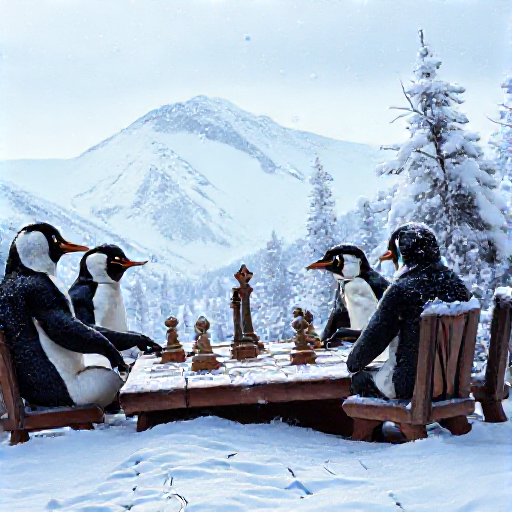

In [ ]:
prompt = "Penguin playing chess at a wooden table in a snowy landscape."

seed = 17
skip_layers = 10

image = pipe(
    prompt=prompt,
    guidance_scale=0.0,
    height=512,
    width=512,
    num_inference_steps=1,
    skip_layers=skip_layers,
    generator=torch.Generator(device).manual_seed(seed),
).images[0]
display(image)

CLIP MASKED
Skiping num layers:  20


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

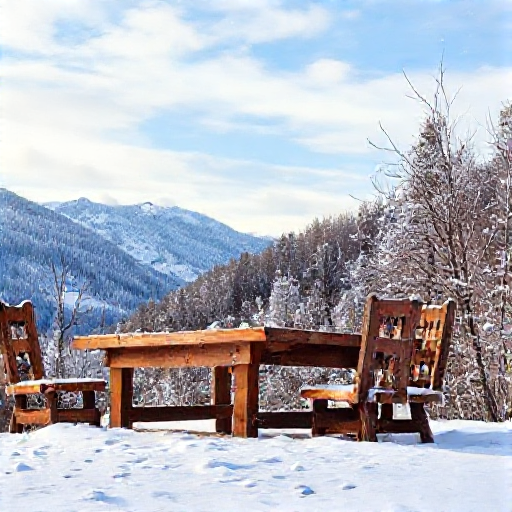

In [ ]:
prompt = "Penguin playing chess at a wooden table in a snowy landscape."

seed = 17
skip_layers = 20

image = pipe(
    prompt=prompt,
    guidance_scale=0.0,
    height=512,
    width=512,
    num_inference_steps=1,
    skip_layers=skip_layers,
    generator=torch.Generator(device).manual_seed(seed),
).images[0]
display(image)